In [ ]:
# we unzip the dataset onto google colab
!unzip -q /content/dataset.zip -d /content/
print("Unzip complete!")

Unzip complete!


In [ ]:
import os
import cv2
import numpy as np
import glob
from tqdm import tqdm

BASE_DIR = '/content/dataset'
SUBSETS = ['train', 'val', 'test']

def yolo_to_mask(image_path, label_path, output_path):
    if not os.path.exists(image_path):
        return

    img = cv2.imread(image_path)
    if img is None:
        return
    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            parts = list(map(float, line.strip().split()))
            coords = parts[1:]

            points = np.array(coords).reshape(-1, 2)
            points[:, 0] *= w
            points[:, 1] *= h


            points = points.astype(np.int32)


            cv2.fillPoly(mask, [points], color=255)

    cv2.imwrite(output_path, mask)


print("Generating masks...")

for subset in SUBSETS:
    image_dir = os.path.join(BASE_DIR, subset, 'images')
    label_dir = os.path.join(BASE_DIR, subset, 'labels')
    mask_dir = os.path.join(BASE_DIR, subset, 'masks') # We create this folder


    os.makedirs(mask_dir, exist_ok=True)

    # here we try to find the JPG images
    image_files = glob.glob(os.path.join(image_dir, '*.jpg'))
    print(f"Processing {subset}: {len(image_files)} images...")

    for img_path in tqdm(image_files):
        filename = os.path.basename(img_path)
        name_no_ext = os.path.splitext(filename)[0]

        label_path = os.path.join(label_dir, name_no_ext + '.txt')
        output_path = os.path.join(mask_dir, name_no_ext + '.png')

        yolo_to_mask(img_path, label_path, output_path)

print("\n Success! Masks created in 'masks' folders.")

Generating masks...
Processing train: 815 images...


100%|██████████| 815/815 [00:05<00:00, 159.92it/s]


Processing val: 101 images...


100%|██████████| 101/101 [00:00<00:00, 190.11it/s]


Processing test: 103 images...


100%|██████████| 103/103 [00:00<00:00, 199.38it/s]


Success! Masks created in 'masks' folders.


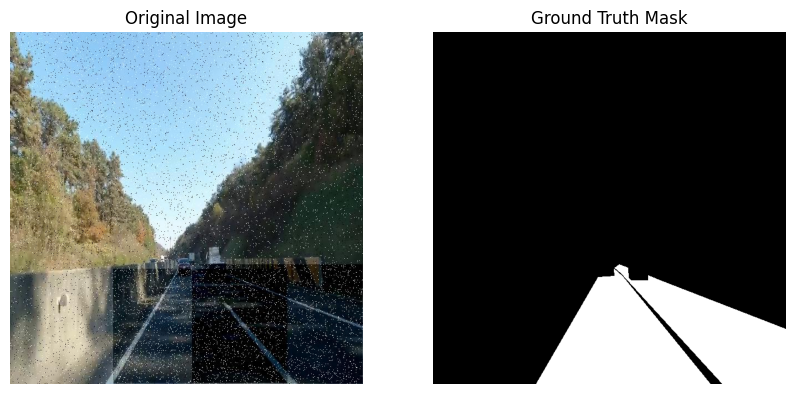

In [ ]:
import matplotlib.pyplot as plt
import random

train_img_dir = '/content/dataset/train/images'
train_mask_dir = '/content/dataset/train/masks'

random_file = random.choice(os.listdir(train_img_dir))
name_no_ext = os.path.splitext(random_file)[0]

img_path = os.path.join(train_img_dir, random_file)
mask_path = os.path.join(train_mask_dir, name_no_ext + '.png')

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Ground Truth Mask")
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

Evaluating Classical Method on 103 test images...


100%|██████████| 103/103 [00:01<00:00, 68.87it/s] 


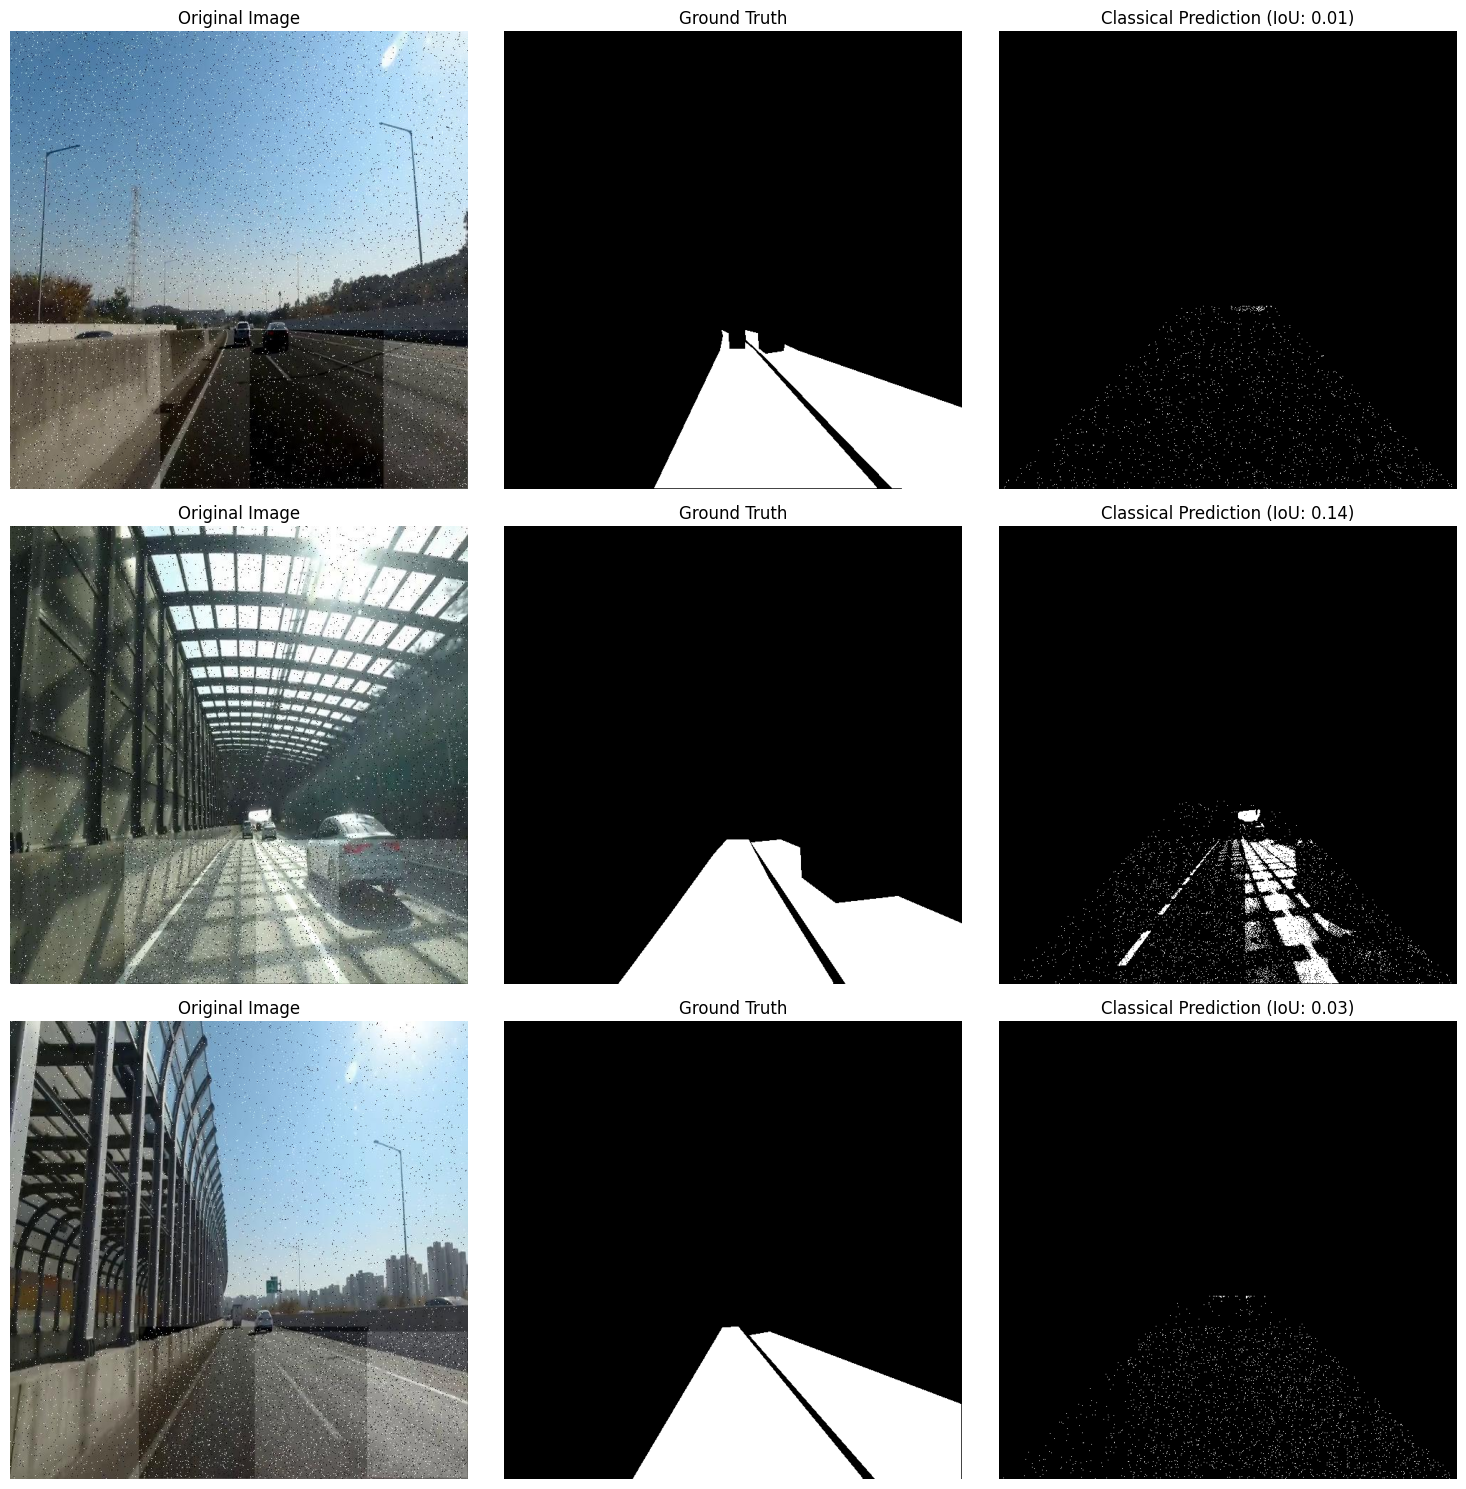


Average IoU Score: 0.0470
Note: Classical methods usually score lower (0.2 - 0.4) because they are sensitive to lighting.


In [ ]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. The Classical Alogrthim

def classical_segmentation(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

    # color selection
    # 1. white mask: High Lightness
    lower_white = np.array([0, 200, 0])
    upper_white = np.array([255, 255, 255])
    white_mask = cv2.inRange(hls, lower_white, upper_white)

    # 2. yellow mask: specific Hue and saturation
    lower_yellow = np.array([15, 30, 115])
    upper_yellow = np.array([35, 204, 255])
    yellow_mask = cv2.inRange(hls, lower_yellow, upper_yellow)

    # then we combine the masks
    combined_mask = cv2.bitwise_or(white_mask, yellow_mask)

    # Region of Interest
    # We assume lanes are in the bottom half of the image
    h, w = img.shape[:2]
    roi_mask = np.zeros_like(combined_mask)

    # Define a polygon for the road area
    # Points: bottom Left, top keft, top right, bottom right
    polygon = np.array([[
        (0, h),
        (w * 0.4, h * 0.6),
        (w * 0.6, h * 0.6),
        (w, h)
    ]], np.int32)

    cv2.fillPoly(roi_mask, polygon, 255)

    # then we apply the roi to the color mask
    final_mask = cv2.bitwise_and(combined_mask, roi_mask)

    return final_mask


# 2. IoU Metric

def calculate_iou(pred_mask, true_mask):

    pred = (pred_mask > 0).astype(np.uint8)
    true = (true_mask > 0).astype(np.uint8)

    intersection = np.logical_and(pred, true).sum()
    union = np.logical_or(pred, true).sum()

    if union == 0:
        return 0.0 if intersection == 0 else 0.0

    return intersection / union


# 3. Running on Test Set

test_img_dir = '/content/dataset/test/images'
test_mask_dir = '/content/dataset/test/masks'

image_paths = glob.glob(os.path.join(test_img_dir, '*.jpg'))
iou_scores = []

print(f"Evaluating Classical Method on {len(image_paths)} test images...")


visualize_count = 3
plt.figure(figsize=(15, 5 * visualize_count))

for i, img_path in enumerate(tqdm(image_paths)):
    img = cv2.imread(img_path)
    if img is None: continue


    filename = os.path.basename(img_path)
    name_no_ext = os.path.splitext(filename)[0]
    gt_path = os.path.join(test_mask_dir, name_no_ext + '.png')

    if not os.path.exists(gt_path):
        continue

    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

    pred_mask = classical_segmentation(img)


    score = calculate_iou(pred_mask, gt_mask)
    iou_scores.append(score)

    if i < visualize_count:
        plt.subplot(visualize_count, 3, i*3 + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(visualize_count, 3, i*3 + 2)
        plt.imshow(gt_mask, cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(visualize_count, 3, i*3 + 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title(f"Classical Prediction (IoU: {score:.2f})")
        plt.axis('off')

plt.tight_layout()
plt.show()

avg_iou = np.mean(iou_scores)
print(f"\nAverage IoU Score: {avg_iou:.4f}")
print("Note: Classical methods usually score lower (0.2 - 0.4) because they are sensitive to lighting.")

Using device: cuda
Starting Training...


Epoch 1/60: 100%|██████████| 102/102 [00:39<00:00,  2.60it/s]


Epoch 1 Loss: 0.4542


Epoch 2/60: 100%|██████████| 102/102 [00:38<00:00,  2.62it/s]


Epoch 2 Loss: 0.3327


Epoch 3/60: 100%|██████████| 102/102 [00:37<00:00,  2.69it/s]


Epoch 3 Loss: 0.3044


Epoch 4/60: 100%|██████████| 102/102 [00:38<00:00,  2.66it/s]


Epoch 4 Loss: 0.2829


Epoch 5/60: 100%|██████████| 102/102 [00:38<00:00,  2.66it/s]


Epoch 5 Loss: 0.2587


Epoch 6/60: 100%|██████████| 102/102 [00:38<00:00,  2.67it/s]


Epoch 6 Loss: 0.2433


Epoch 7/60: 100%|██████████| 102/102 [00:38<00:00,  2.67it/s]


Epoch 7 Loss: 0.2262


Epoch 8/60: 100%|██████████| 102/102 [00:38<00:00,  2.67it/s]


Epoch 8 Loss: 0.2080


Epoch 9/60: 100%|██████████| 102/102 [00:38<00:00,  2.68it/s]


Epoch 9 Loss: 0.2107


Epoch 10/60: 100%|██████████| 102/102 [00:38<00:00,  2.67it/s]


Epoch 10 Loss: 0.1916


Epoch 11/60: 100%|██████████| 102/102 [00:38<00:00,  2.67it/s]


Epoch 11 Loss: 0.1765


Epoch 12/60: 100%|██████████| 102/102 [00:38<00:00,  2.67it/s]


Epoch 12 Loss: 0.1743


Epoch 13/60: 100%|██████████| 102/102 [00:38<00:00,  2.67it/s]


Epoch 13 Loss: 0.1656


Epoch 14/60: 100%|██████████| 102/102 [00:38<00:00,  2.66it/s]


Epoch 14 Loss: 0.1589


Epoch 15/60: 100%|██████████| 102/102 [00:38<00:00,  2.66it/s]


Epoch 15 Loss: 0.1488


Epoch 16/60: 100%|██████████| 102/102 [00:38<00:00,  2.65it/s]


Epoch 16 Loss: 0.1379


Epoch 17/60: 100%|██████████| 102/102 [00:38<00:00,  2.66it/s]


Epoch 17 Loss: 0.1382


Epoch 18/60: 100%|██████████| 102/102 [00:38<00:00,  2.66it/s]


Epoch 18 Loss: 0.1322


Epoch 19/60: 100%|██████████| 102/102 [00:38<00:00,  2.65it/s]


Epoch 19 Loss: 0.1288


Epoch 20/60: 100%|██████████| 102/102 [00:38<00:00,  2.67it/s]


Epoch 20 Loss: 0.1235


Epoch 21/60: 100%|██████████| 102/102 [00:38<00:00,  2.66it/s]


Epoch 21 Loss: 0.1154


Epoch 22/60: 100%|██████████| 102/102 [00:38<00:00,  2.66it/s]


Epoch 22 Loss: 0.1199


Epoch 23/60: 100%|██████████| 102/102 [00:38<00:00,  2.66it/s]


Epoch 23 Loss: 0.1134


Epoch 24/60: 100%|██████████| 102/102 [00:38<00:00,  2.66it/s]


Epoch 24 Loss: 0.1063


Epoch 25/60: 100%|██████████| 102/102 [00:38<00:00,  2.68it/s]


Epoch 25 Loss: 0.1033


Epoch 26/60: 100%|██████████| 102/102 [00:38<00:00,  2.67it/s]


Epoch 26 Loss: 0.0975


Epoch 27/60: 100%|██████████| 102/102 [00:37<00:00,  2.69it/s]


Epoch 27 Loss: 0.0996


Epoch 28/60: 100%|██████████| 102/102 [00:38<00:00,  2.67it/s]


Epoch 28 Loss: 0.0956


Epoch 29/60: 100%|██████████| 102/102 [00:37<00:00,  2.69it/s]


Epoch 29 Loss: 0.0947


Epoch 30/60: 100%|██████████| 102/102 [00:38<00:00,  2.66it/s]


Epoch 30 Loss: 0.0902


Epoch 31/60: 100%|██████████| 102/102 [00:38<00:00,  2.65it/s]


Epoch 31 Loss: 0.1029


Epoch 32/60: 100%|██████████| 102/102 [00:38<00:00,  2.66it/s]


Epoch 32 Loss: 0.0826


Epoch 33/60: 100%|██████████| 102/102 [00:38<00:00,  2.65it/s]


Epoch 33 Loss: 0.0850


Epoch 34/60: 100%|██████████| 102/102 [00:38<00:00,  2.65it/s]


Epoch 34 Loss: 0.0793


Epoch 35/60: 100%|██████████| 102/102 [00:38<00:00,  2.64it/s]


Epoch 35 Loss: 0.0788


Epoch 36/60: 100%|██████████| 102/102 [00:38<00:00,  2.66it/s]


Epoch 36 Loss: 0.0809


Epoch 37/60: 100%|██████████| 102/102 [00:38<00:00,  2.64it/s]


Epoch 37 Loss: 0.0789


Epoch 38/60: 100%|██████████| 102/102 [00:38<00:00,  2.65it/s]


Epoch 38 Loss: 0.0765


Epoch 39/60: 100%|██████████| 102/102 [00:38<00:00,  2.65it/s]


Epoch 39 Loss: 0.0737


Epoch 40/60: 100%|██████████| 102/102 [00:38<00:00,  2.64it/s]


Epoch 40 Loss: 0.0714


Epoch 41/60: 100%|██████████| 102/102 [00:38<00:00,  2.65it/s]


Epoch 41 Loss: 0.0715


Epoch 42/60: 100%|██████████| 102/102 [00:38<00:00,  2.65it/s]


Epoch 42 Loss: 0.0681


Epoch 43/60: 100%|██████████| 102/102 [00:38<00:00,  2.67it/s]


Epoch 43 Loss: 0.0653


Epoch 44/60: 100%|██████████| 102/102 [00:37<00:00,  2.68it/s]


Epoch 44 Loss: 0.0658


Epoch 45/60: 100%|██████████| 102/102 [00:37<00:00,  2.70it/s]


Epoch 45 Loss: 0.0741


Epoch 46/60: 100%|██████████| 102/102 [00:38<00:00,  2.68it/s]


Epoch 46 Loss: 0.0596


Epoch 47/60: 100%|██████████| 102/102 [00:37<00:00,  2.69it/s]


Epoch 47 Loss: 0.0725


Epoch 48/60: 100%|██████████| 102/102 [00:38<00:00,  2.67it/s]


Epoch 48 Loss: 0.0590


Epoch 49/60: 100%|██████████| 102/102 [00:38<00:00,  2.65it/s]


Epoch 49 Loss: 0.0589


Epoch 50/60: 100%|██████████| 102/102 [00:38<00:00,  2.65it/s]


Epoch 50 Loss: 0.0573


Epoch 51/60: 100%|██████████| 102/102 [00:38<00:00,  2.67it/s]


Epoch 51 Loss: 0.0594


Epoch 52/60: 100%|██████████| 102/102 [00:38<00:00,  2.66it/s]


Epoch 52 Loss: 0.0556


Epoch 53/60: 100%|██████████| 102/102 [00:38<00:00,  2.66it/s]


Epoch 53 Loss: 0.0545


Epoch 54/60: 100%|██████████| 102/102 [00:38<00:00,  2.66it/s]


Epoch 54 Loss: 0.0602


Epoch 55/60: 100%|██████████| 102/102 [00:38<00:00,  2.67it/s]


Epoch 55 Loss: 0.0588


Epoch 56/60: 100%|██████████| 102/102 [00:38<00:00,  2.66it/s]


Epoch 56 Loss: 0.0535


Epoch 57/60: 100%|██████████| 102/102 [00:38<00:00,  2.66it/s]


Epoch 57 Loss: 0.0524


Epoch 58/60: 100%|██████████| 102/102 [00:38<00:00,  2.64it/s]


Epoch 58 Loss: 0.0495


Epoch 59/60: 100%|██████████| 102/102 [00:38<00:00,  2.64it/s]


Epoch 59 Loss: 0.0470


Epoch 60/60: 100%|██████████| 102/102 [00:38<00:00,  2.66it/s]


Epoch 60 Loss: 0.0468


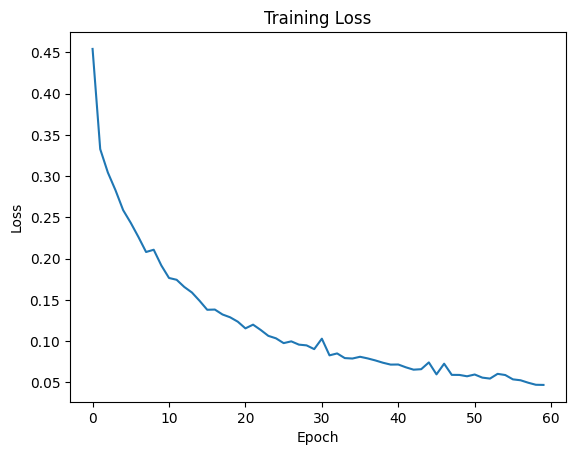

Evaluating Deep Learning Model...


100%|██████████| 103/103 [00:02<00:00, 40.42it/s]


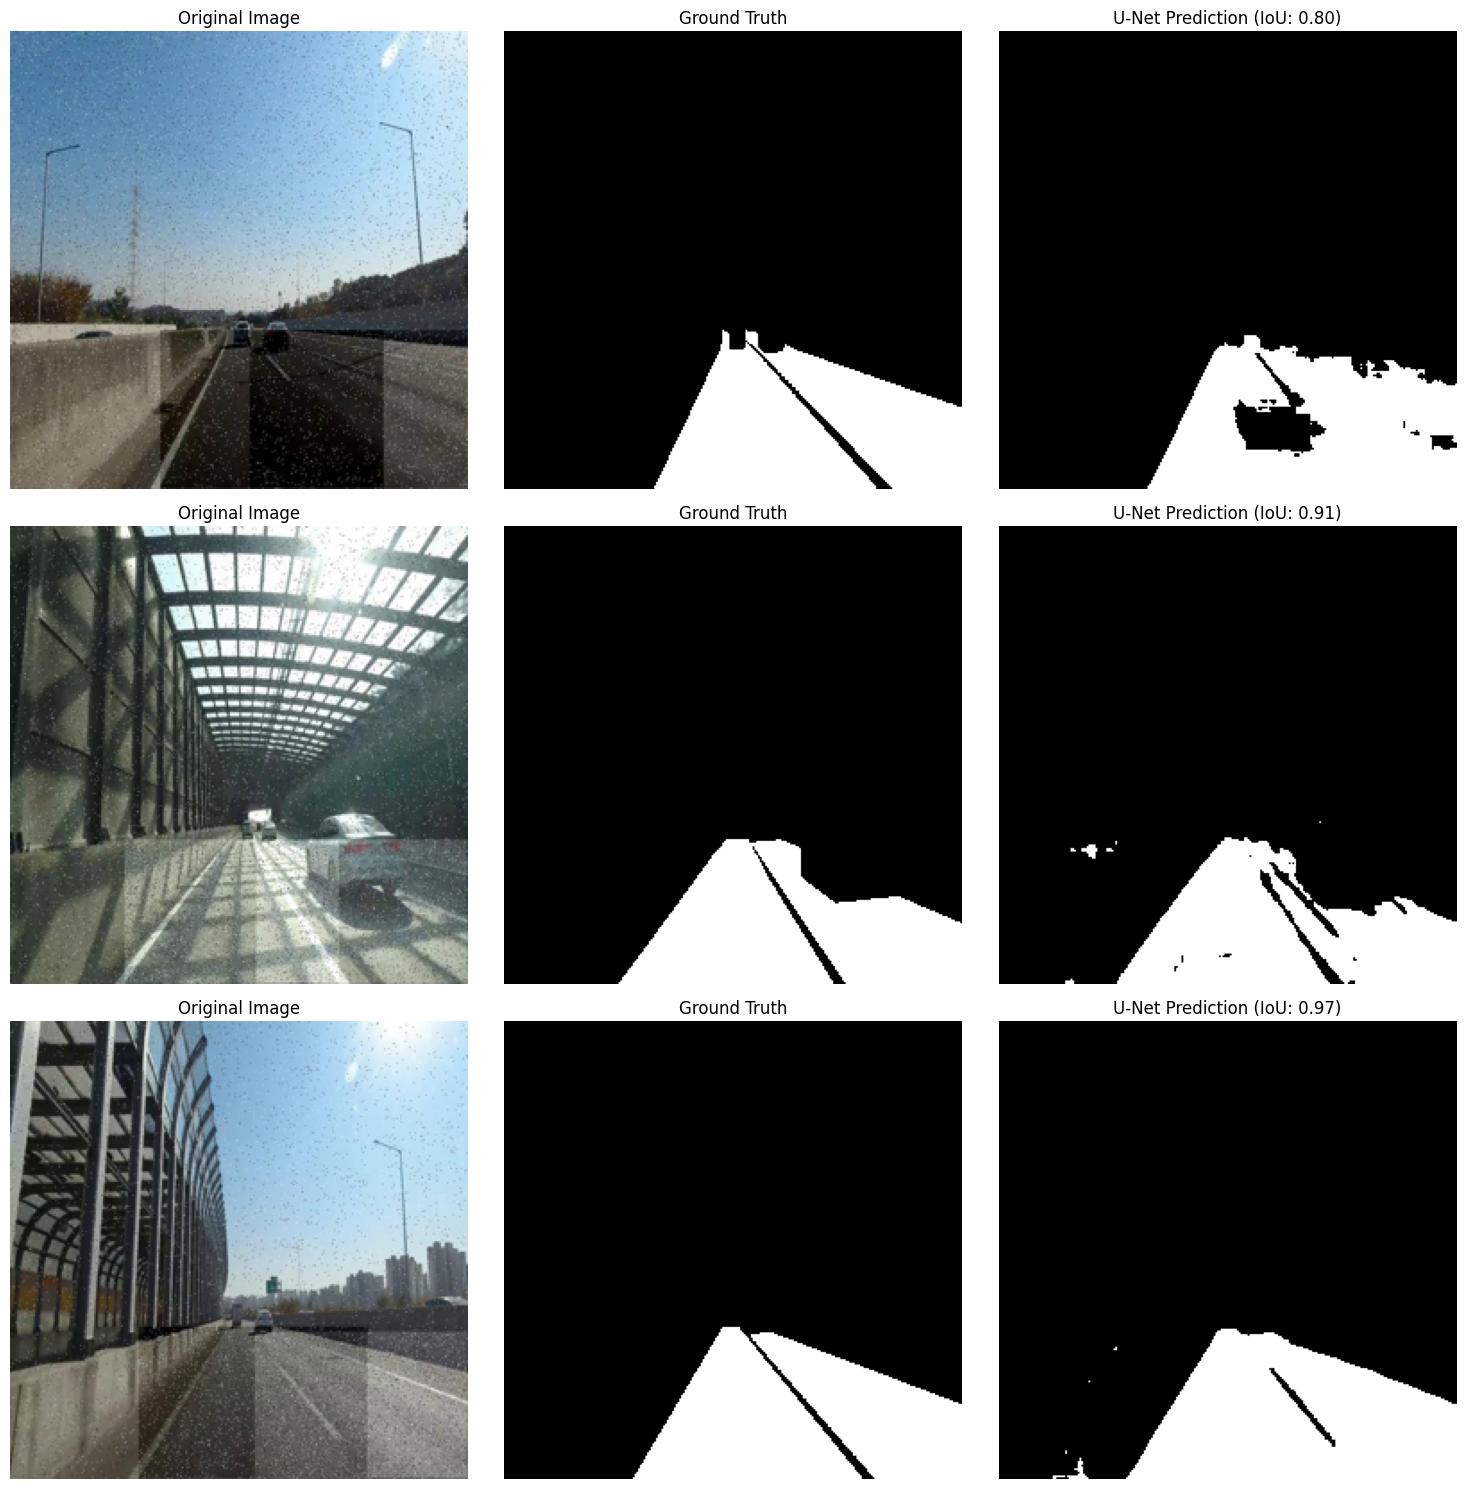


Deep Learning Average IoU: 0.8657
Comparison: Classical was 0.047 vs Deep Learning 0.8657


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


# Configuration & Setup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

BATCH_SIZE = 8
LEARNING_RATE = 1e-4
EPOCHS = 60
IMG_SIZE = (256, 256)


# Custom Dataset Loader

class LaneDataset(Dataset):
    def __init__(self, root_dir, subset, transform=None):
        self.root_dir = root_dir
        self.subset = subset
        self.transform = transform

        self.img_dir = os.path.join(root_dir, subset, 'images')
        self.mask_dir = os.path.join(root_dir, subset, 'masks')

        # this is the list of images
        self.images = [f for f in os.listdir(self.img_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # this finds the matching mask
        mask_name = os.path.splitext(img_name)[0] + '.png'
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") # grayscale
        image = image.resize(IMG_SIZE)
        mask = mask.resize(IMG_SIZE)

        # here we convert to tensor
        # now the image is normalized 0-1
        # we want the mask in binary

        img_tensor = transforms.ToTensor()(image)
        mask_tensor = transforms.ToTensor()(mask)
        mask_tensor = (mask_tensor > 0.5).float()

        return img_tensor, mask_tensor

base_dir = '/content/dataset'
train_dataset = LaneDataset(base_dir, 'train')
val_dataset = LaneDataset(base_dir, 'val')
test_dataset = LaneDataset(base_dir, 'test')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Define U-Net Architecture

class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()


        self.enc1 = self.conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = self.conv_block(128, 256)


        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = self.conv_block(128, 64)


        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):

        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)


        b = self.enc3(p2)

        d2 = self.up2(b)

        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)

        return torch.sigmoid(self.final(d1))

# U-net model
model = SimpleUNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


# Training Loop

print("Starting Training...")
train_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


# evaluation & visualization

model.eval()
iou_scores = []
visualize_count = 3
cols = 3

plt.figure(figsize=(15, 5 * visualize_count))
plot_idx = 0

print("Evaluating Deep Learning Model...")

with torch.no_grad():
    for i, (image, mask) in enumerate(tqdm(test_loader)):
        image = image.to(device)
        mask = mask.to(device)


        output = model(image)
        pred_mask = (output > 0.5).float()

        # we calculate IoU
        intersection = (pred_mask * mask).sum().item()
        union = (pred_mask + mask).sum().item() - intersection
        if union == 0:
            iou = 1.0
        else:
            iou = intersection / union
        iou_scores.append(iou)


        if plot_idx < visualize_count:

            img_np = image.squeeze().cpu().permute(1, 2, 0).numpy()
            mask_np = mask.squeeze().cpu().numpy()
            pred_np = pred_mask.squeeze().cpu().numpy()

            plt.subplot(visualize_count, cols, plot_idx*cols + 1)
            plt.imshow(img_np)
            plt.title("Original Image")
            plt.axis('off')

            plt.subplot(visualize_count, cols, plot_idx*cols + 2)
            plt.imshow(mask_np, cmap='gray')
            plt.title("Ground Truth")
            plt.axis('off')

            plt.subplot(visualize_count, cols, plot_idx*cols + 3)
            plt.imshow(pred_np, cmap='gray')
            plt.title(f"U-Net Prediction (IoU: {iou:.2f})")
            plt.axis('off')

            plot_idx += 1

plt.tight_layout()
plt.show()

print(f"\nDeep Learning Average IoU: {np.mean(iou_scores):.4f}")
print(f"Comparison: Classical was 0.047 vs Deep Learning {np.mean(iou_scores):.4f}")

In [ ]:
import time


# Accuracy & Speed

model.eval()

total_acc = 0.0
total_time = 0.0
num_batches = 0

print("Calculating Accuracy and Speed...")

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)


        start_time = time.time()
        outputs = model(images)
        end_time = time.time()


        total_time += (end_time - start_time)


        preds = (outputs > 0.5).float()
        correct_pixels = (preds == masks).sum().item()
        total_pixels = torch.numel(preds)

        accuracy = correct_pixels / total_pixels
        total_acc += accuracy

        num_batches += 1

avg_acc = total_acc / num_batches
avg_time_per_img = total_time / len(test_loader.dataset)
fps = 1.0 / avg_time_per_img

print("\n Final Evaluation Report")
print(f"Pixel Accuracy:      {avg_acc*100:.2f}%")
print(f"Average IoU:         {np.mean(iou_scores):.4f}")
print(f"Inference Time:      {avg_time_per_img*1000:.2f} ms per image")
print(f"Speed:               {fps:.2f} FPS (Frames Per Second)")

Calculating Accuracy and Speed...

=== Final Evaluation Report ===
Pixel Accuracy:      97.70%
Average IoU:         0.8657
Inference Time:      1.19 ms per image
Speed:               842.01 FPS (Frames Per Second)


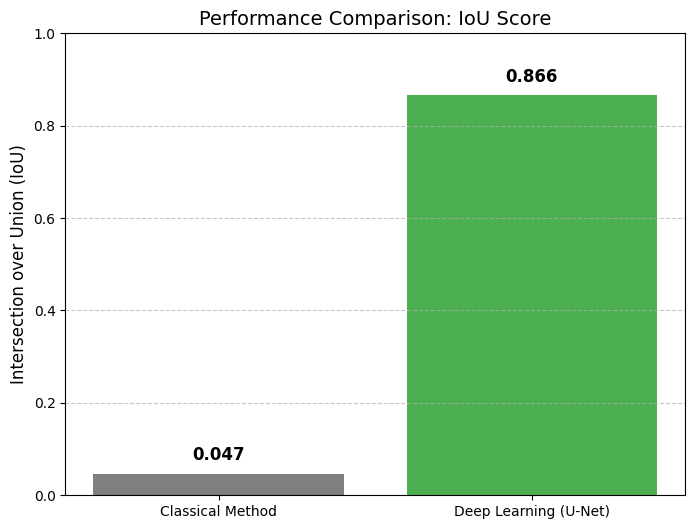

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

methods = ['Classical Method', 'Deep Learning (U-Net)']
iou_scores = [0.047, 0.866]

# bar Chart
plt.figure(figsize=(8, 6))
bars = plt.bar(methods, iou_scores, color=['gray', '#4CAF50'])

plt.title('Performance Comparison: IoU Score', fontsize=14)
plt.ylabel('Intersection over Union (IoU)', fontsize=12)
plt.ylim(0, 1.0)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.02,
             f'{height:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()